[目录](./table_of_contents.ipynb)

# 非线性滤波

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

## 概述

我们开发的卡尔曼滤波器使用线性方程，因此滤波器只能处理线性问题。但是这个世界是非线性的，所以我们目前所研究的经典过滤器的效用非常有限。

过程模型中可能存在非线性。假设我们想追踪一个穿过大气层的物体。物体的加速度取决于它所遭遇的阻力。阻力取决于空气密度，空气密度随高度而减小。在一维情况下，可以用非线性微分方程来表示

$$\ddot x = \frac{0.0034ge^{-x/22000}\dot x^2}{2\beta} - g$$

非线性的第二个来源来自测量。例如，雷达测量一个物体的倾斜范围，而我们通常感兴趣的是飞机在地面上的位置。我们调用毕达哥拉斯，得到非线性方程:

$$x=\sqrt{\mathtt{slant}^2 - \mathtt{altitude}^2}$$

这些事实并没有被卡尔曼滤波器的早期采用者所忽视。在卡尔曼博士发表他的论文后不久，人们就开始研究如何将卡尔曼滤波器扩展到非线性问题。

几乎可以说，人们唯一知道如何解的方程是$\mathbf{Ax}=\mathbf{b}$。我们只知道怎么做线性代数。我可以给你任何线性方程组你可以解它或者证明它没有解。

任何受过正规数学或物理教育的人都花了数年时间学习各种解析方法来解积分、微分方程等。然而，即使是微不足道的物理系统也会产生无法解析解的方程。我可以取一个你能积分的方程，插入$\log$项，使它不可解。这就引出了物理学家的笑话:“假设真空中无摩擦的表面上有一头球形奶牛……”如果不做极端的简化，大多数物理问题都没有解析解。
 
我们如何在计算机中模拟飞机上方的气流，或预测天气，或使用卡尔曼滤波器跟踪导弹?我们退回到已知的:$\mathbf{Ax}=\mathbf{b}$。我们找到了一些方法来线性化这个问题，把它变成一组线性方程，然后使用线性代数软件包来计算一个近似的解。
 
将非线性问题线性化会得到不准确的答案，而在卡尔曼滤波或天气跟踪系统这样的递归算法中，这些小错误有时会在每一步中相互强化，很快导致算法产生无意义的结果。

我们将要着手解决的是一个难题。没有一个明显的，正确的，数学上最优的解了。我们将使用近似，我们将在计算中引入错误，我们将永远与“发散”滤波器斗争，也就是说，滤波器的数值误差超过了解。

在这一小章的剩余部分，我将说明非线性卡尔曼滤波器面临的具体问题。只有在理解问题的非线性导致的特定问题之后，才能设计滤波器。随后的章节将教你如何设计和实现不同类型的非线性滤波器。

## 非线性的问题

卡尔曼滤波器的数学很漂亮，部分原因是高斯方程很特殊。它是非线性的，但是当我们把它们相加相乘得到的是另一个高斯分布。这是非常罕见的。$ sin{x}* sin{y}$不会输出$ sin$。

我所说的线性可能是显而易见的，但也有一些微妙之处。数学要求是双重的:

* additivity: $f(x+y) = f(x) + f(y)$
* homogeneity: $f(ax) = af(x)$

这使得我们说一个线性系统被定义为一个系统它的输出与它所有的输入的和成线性比例。结果是，如果输入为零，那么输出也必须为零。考虑一个音频放大器——如果我对着麦克风唱歌，而你开始说话，输出应该是我们的声音(输入)的总和，按放大器增益的比例缩放。但是，如果放大器输出一个非零信号，比如零输入的嗡嗡声，则加性关系不再成立。这是因为线性要求$amp(voice) = amp(voice + 0)$。这显然应该给出相同的输出，但是如果amp(0)是非零的，那么

$$
\begin{aligned}
amp(voice) &= amp(voice + 0) \\
&= amp(voice) + amp(0) \\
&= amp(voice) + non\_zero\_value
\end{aligned}
$$

这显然是无稽之谈。因此，一个明显的线性方程，如

$$L(f(t)) = f(t) + 1$$

不是线性的，因为$L(0) = 1$。小心!

## 凭直觉看问题

我特别喜欢下面的方法来看待这个问题，我借用了Dan Simon的*Optimal State Estimation*[[1]](#[1])。考虑一个跟踪问题我们得到目标的距离和方位，我们想要跟踪它的位置。报告的距离是50公里，报告的角度是90$^\circ$。假设距离和角度上的误差均为高斯分布。给定无限次测量，位置的期望值是多少?

我一直建议用直觉来理解，我们来看看这个问题的结果如何。因为距离的均值是50千米，角度的均值是90$^\circ$，所以答案是x=0 km, y=50 km。

我们把它画出来。这里有3000个点，距离的正态分布是0.4 km，角度的正态分布是0.35弧度。我们计算所有位置的平均值，并将其显示为星号。我们的直觉用一个大圆来表示。

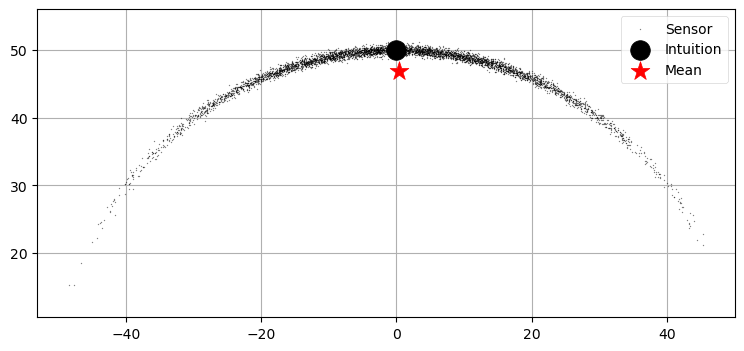

In [3]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

N = 5000
a = np.pi/2. + (randn(N) * 0.35)
r = 50.0     + (randn(N) * 0.4)
xs = r * np.cos(a)
ys = r * np.sin(a)

plt.scatter(xs, ys, label='Sensor', color='k', 
            alpha=0.4, marker='.', s=1)
xmean, ymean = sum(xs) / N, sum(ys) / N
plt.scatter(0, 50, c='k', marker='o', s=200, label='Intuition')
plt.scatter(xmean, ymean, c='r', marker='*', s=200, label='Mean')
plt.axis('equal')
plt.legend();

我们可以看到，我们的直觉失败了，因为问题的非线性迫使所有的错误都偏向一个方向。这种偏差，经过多次迭代，会导致卡尔曼滤波器发散。即使不发散，解也不是最优解。将线性近似应用于非线性问题会得到不准确的结果。

## 非线性函数对高斯的影响

高斯函数在任意非线性函数下不是封闭的。回想一下卡尔曼滤波器的方程——在每次进化时，我们通过表示状态的高斯函数来得到时刻$k$的高斯函数。过程函数总是线性的，所以输出总是另一个高斯函数。我们来看看图表。我将取一个任意的高斯函数，通过函数$f(x) = 2x + 1$，并绘制结果。我们知道如何分析，但我们用抽样法。我将生成50万个正态分布点，将它们传递到$f(x)$，然后绘制结果。我这样做是因为下一个例子是非线性的，我们没有办法解析地计算它。


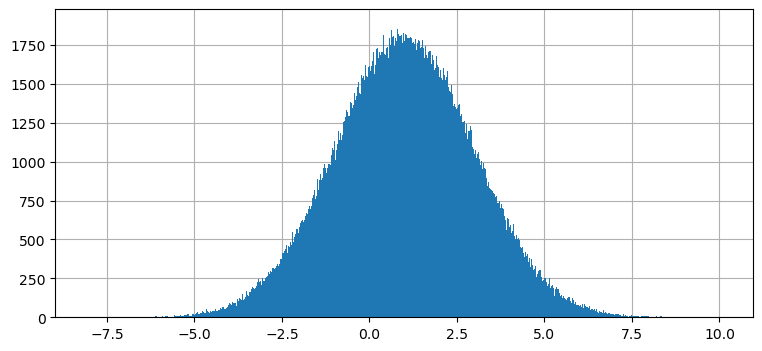

In [4]:
from numpy.random import normal

data = normal(loc=0., scale=1., size=500000)
plt.hist(2*data + 1, 1000);

这是一个不足为奇的结果。通过$f(x)=2x+1$传递高斯函数的结果是另一个以1为中心的高斯函数。让我们同时看看输入、非线性函数和输出。

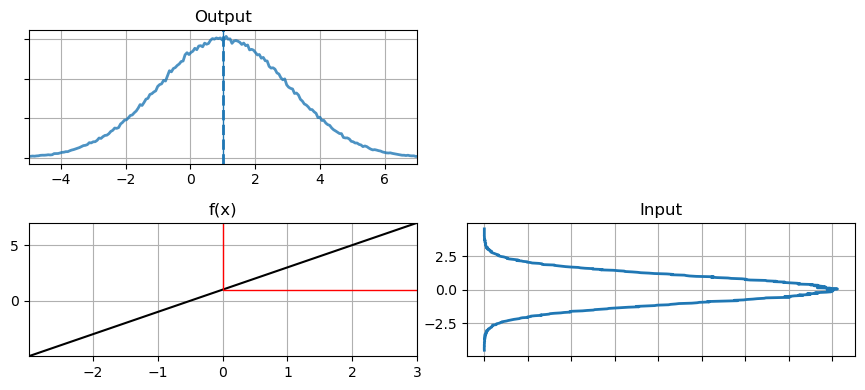

In [5]:
from kf_book.book_plots import set_figsize, figsize
from kf_book.nonlinear_plots import plot_nonlinear_func

def g1(x):
    return 2*x+1

plot_nonlinear_func(data, g1)

>我解释了如何绘制高斯函数，以及更多，在Notebook * computing_and_plotting_pdf * 中
Supporting_Notebooks文件夹。你也可以在线阅读[这里](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Supporting_Notebooks/Computing_and_plotting_PDFs.ipynb)[1]

标有“Input”的图是原始数据的直方图。这是通过函数$f(x)=2x+1$传递的，该函数显示在左下角的图表中。红线显示了一个值$x=0$是如何通过函数传递的。输入中的每个值都以相同的方式传递给右边的输出函数。对于输出，我通过取所有点的平均值来计算平均值，然后用蓝色虚线画出结果。一条蓝色实线表示$x=0$点的实际均值。输出看起来像高斯函数，实际上也是高斯函数。我们可以看到,在输出方差的方差大于输入,和均值从0到1,这是我们期望得到传递函数$f(x)=2x+1$  $2x$ 影响方差,和$+1$的变化意味着计算均值,蓝色的点线所代表的,几乎是等于实际的意思。如果我们在计算中使用更多的点，我们可以得到任意接近实际值的点。

现在我们来看一个非线性函数看看它是如何影响概率分布的。

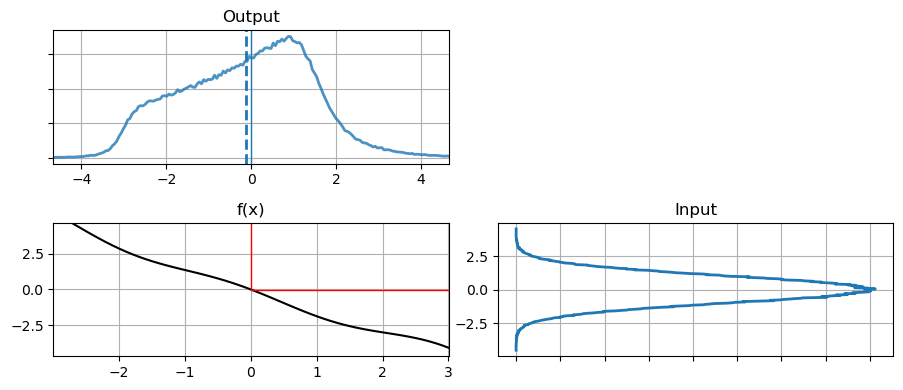

In [6]:
def g2(x):
    return (np.cos(3*(x/2 + 0.7))) * np.sin(0.3*x) - 1.6*x

plot_nonlinear_func(data, g2)

这个结果可能会让你有些吃惊。这个函数看起来“相当”线性，但输出的概率分布完全不同于高斯分布。回想一下两个单变量高斯函数相乘的方程:

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2} \\
\sigma &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}$$

这些方程对于非高斯分布并不成立，当然对于上面的“输出”图所示的概率分布也不成立。

这是另一种看待散点图的方法。

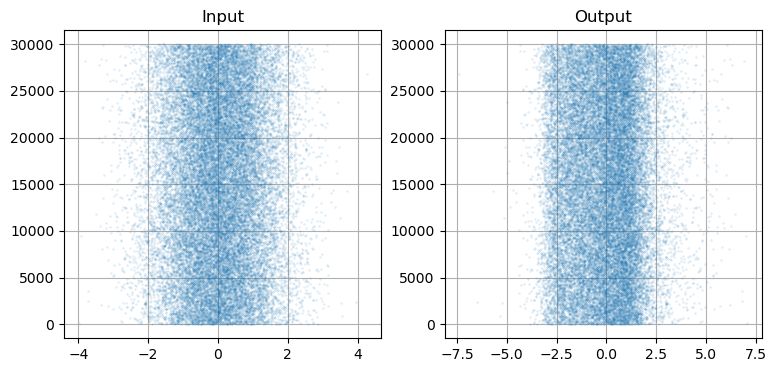

In [7]:
N = 30000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.1, s=1.5)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(g2(data[:N]), range(N), alpha=.1, s=1.5);

原始数据显然是高斯分布，但通过`g2(x)`传递的数据不再是正态分布。在-3附近有一条很厚的带，点不均匀地分布在带的两边。如果你将其与前面图表中标有'output'的pdf相比较，你应该能够看到pdf形状如何匹配`g(data)`的分布。

想想这对前一章的卡尔曼滤波算法意味着什么。所有的方程都假设一个高斯函数通过过程函数会导致另一个高斯函数。如果这不是真的，那么卡尔曼滤波器的所有假设和保证都不成立。让我们看看当我们再次将输出传回函数时，会发生什么，模拟卡尔曼滤波器的下一个时间步长。

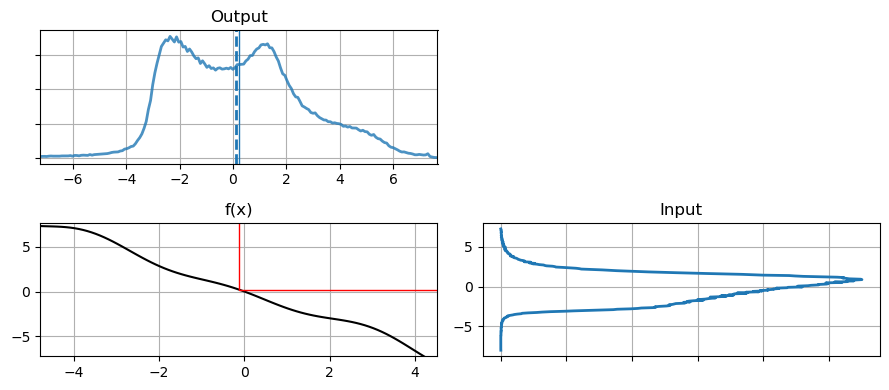

In [8]:
y = g2(data)
plot_nonlinear_func(y, g2)

如你所见，概率函数比原来的高斯函数进一步扭曲。不过，图像仍然是关于x=0对称的，我们看看均值是多少。

In [9]:
print('input  mean, variance: %.4f, %.4f' % 
      (np.mean(data), np.var(data)))
print('output mean, variance: %.4f, %.4f' % 
      (np.mean(y), np.var(y)))

input  mean, variance: 0.0025, 1.0004
output mean, variance: -0.1284, 2.4032


我们把它和通过(-2,3)和(2，-3)的线性函数进行比较，它非常接近我们画出的非线性函数。用已知的直线方程进入翻译页面

$$m=\frac{-3-3}{2-(-2)}=-1.5$$

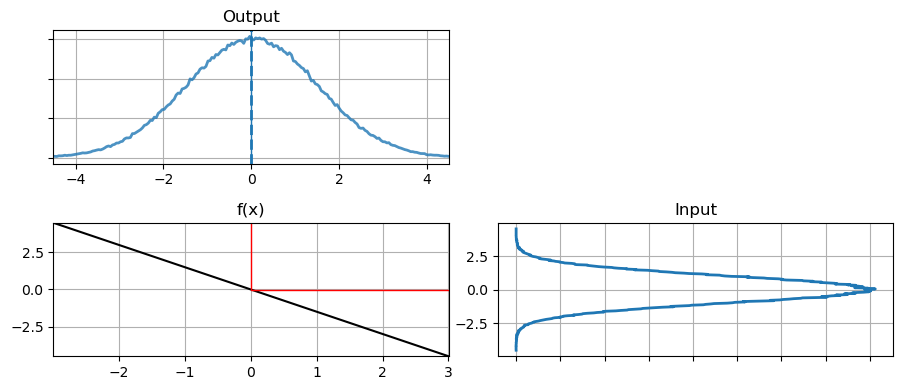

output mean, variance: -0.0038, 2.2508


In [10]:
def g3(x): 
    return -1.5 * x

plot_nonlinear_func(data, g3)
out = g3(data)
print('output mean, variance: %.4f, %.4f' % 
      (np.mean(out), np.var(out)))

尽管输出的形状非常不同，但每个输出的均值和方差几乎是相同的。这可能导致我们推理，也许我们可以忽略这个问题，如果非线性方程是“接近”线性。为了进行测试，我们可以多次迭代，然后比较结果。

In [11]:
out = g3(data)
out2 = g2(data)

for i in range(10):
    out = g3(out)
    out2 = g2(out2)
print('linear    output mean, variance: %.4f, %.4f' % 
      (np.average(out), np.std(out)**2))
print('nonlinear output mean, variance: %.4f, %.4f' % 
      (np.average(out2), np.std(out2)**2))

linear    output mean, variance: 0.0511, 7506.6256
nonlinear output mean, variance: -9.0540, 30529.4381


尽管输出的形状非常不同，但每个输出的均值和方差几乎是相同的。这可能导致我们推理，也许我们可以忽略这个问题，如果非线性方程是“接近”线性。为了进行测试，我们可以多次迭代，然后比较结果。

我通过使用一个非常接近直线的函数来最小化这个问题。如果函数是$y(x)=-x^2$呢?

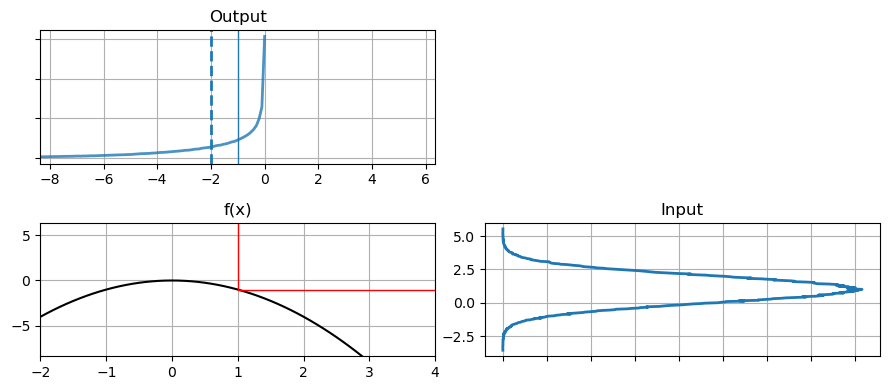

In [11]:
def g3(x): 
    return -x*x

data = normal(loc=1, scale=1, size=500000)
plot_nonlinear_func(data, g3)

尽管在$x=1$时，曲线平滑且相当直，但输出的概率分布看起来一点也不像高斯分布，且输出的计算均值与直接计算的值有很大不同。这不是一个不寻常的函数——一个弹道物体以抛物线运动，这就是你的过滤器需要处理的非线性。如果你回想一下，我们试着追踪一个球，但失败得很惨。这张图可以让你了解为什么过滤器表现如此糟糕。

## 一个二维的例子

我们很难去观察概率分布，并推断出在过滤器中会发生什么。让我们考虑用雷达追踪一架飞机。估计的协方差可能是这样的:

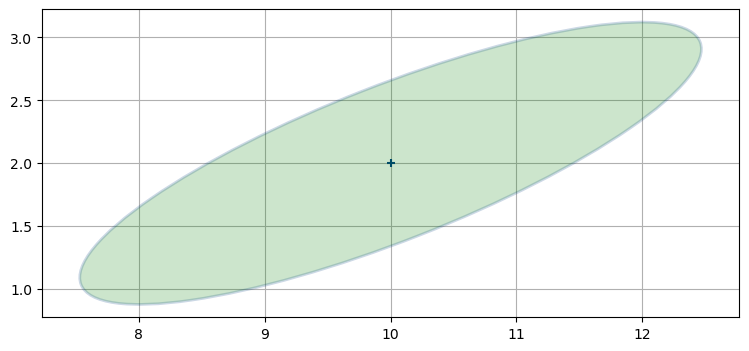

In [12]:
import kf_book.nonlinear_internal as nonlinear_internal

nonlinear_internal.plot1()

当我们试图线性化这个问题时会发生什么?雷达告诉我们飞机的范围。假设雷达在飞机的正下方(x=10)，下一个测量表明飞机在3英里之外(y=3)。与测量值相匹配的位置形成了一个半径为3英里的圆圈，就像这样。

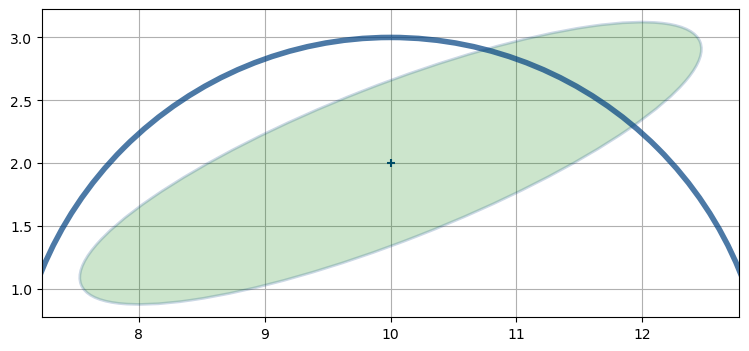

In [13]:
nonlinear_internal.plot2()

我们可以通过检查看到，飞机的可能位置在x=11.4, y=2.7附近，因为那是协方差椭圆和距离测量重叠的地方。但是距离测量是非线性的，所以我们要把它线性化。我们还没有涵盖这个材料，但扩展卡尔曼滤波器将线性化在飞机的最后位置-(10,2)。在x=10处，距离测量值是y=3，因此我们在这一点进行线性化。

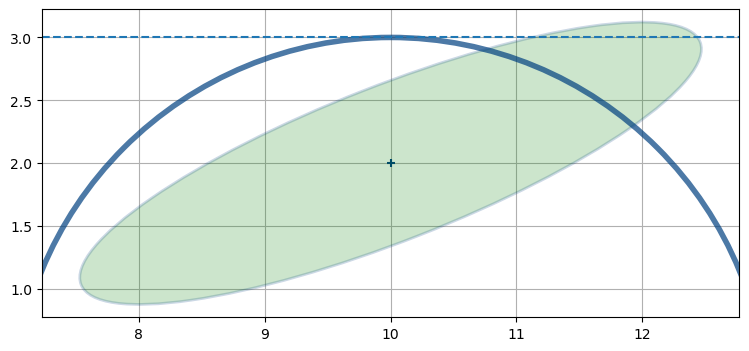

In [14]:
nonlinear_internal.plot3()

现在我们有了问题的线性表示(字面上是一条直线)，我们可以解决它。不幸的是，你可以看到这条线和协方差椭圆的交点离飞机的实际位置很远。

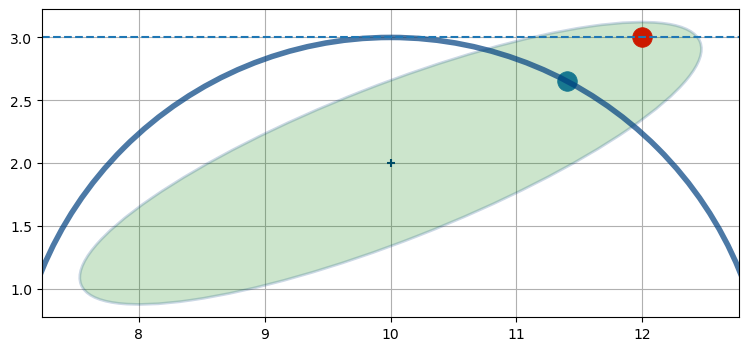

In [15]:
nonlinear_internal.plot4()

这种错误往往会导致灾难性的结果。这一估计的误差很大。但是在滤波器的下一个创新中，这个很差的估计将被用来线性化下一个雷达测量，所以下一个估计很可能比这个差得多。仅仅经过几次迭代，卡尔曼滤波就会发散，并开始产生与现实不相符的结果。

这个协方差椭圆的跨度为英里。我夸大了大小来说明高度非线性系统的困难。在实际的雷达跟踪问题中，非线性问题通常没有那么严重，但误差仍会不断累积。你可能使用的其他系统也可能有这么多的非线性——这不是夸张，只是为了说明一点。在处理非线性系统时，你总是要与散度作斗争。

## 算法

您可能不耐烦地想要解决一个特定的问题，并想知道使用哪个过滤器。我将快速浏览一下选项。后面的章节是相互独立的，你可以有效地跳过，尽管我建议如果你真的想掌握所有的材料，线性阅读。

非线性滤波器的主要工作是线性化卡尔曼滤波器和扩展卡尔曼滤波器(EKF)。这两种技术是在卡尔曼发表论文后不久发明的，从那时起就一直是主要的技术。飞机上的飞行软件、汽车或手机上的GPS几乎肯定使用了这些技术中的一种。

然而，这些技术要求极高。EKF在一点上将微分方程线性化，这需要你找到偏导数矩阵(雅可比矩阵)的解。这在分析上很难或不可能做到。如果不可能，你必须使用数值技术来找到雅可比矩阵，但这是昂贵的计算和引入更多的误差到系统。最后，如果问题是非常非线性的，线性化会导致在每一步引入大量的误差，滤波器经常发散。你不能把一些方程丢到任意的解算器中，然后期望得到好的结果。这对专业人士来说是个困难的领域。我注意到，大多数卡尔曼滤波教科书只是掩盖了EKF，尽管它是现实世界应用中最常用的技术。
 
最近，这个领域正在以令人兴奋的方式发生变化。首先，计算能力已经发展到我们可以使用超级计算机以前无法使用的技术的地步。它们使用了“蒙特卡罗”技术——计算机生成数千到数万个随机点，并根据测量值对所有点进行测试。然后，它根据点数与测量值的匹配程度，有可能杀死或复制点数。远离测量的点不可能被保留，而非常接近的点则很可能被保留。经过几次迭代后，会有一组粒子紧密地跟踪你的目标，而在没有目标的地方会有一组稀疏的点云。
 
这有两个好处。首先，该算法即使对极端非线性问题也具有鲁棒性。其次，该算法可以一次跟踪任意多个对象——一些粒子将匹配一个对象的行为，而其他粒子将匹配其他对象。所以这种技术经常被用来跟踪汽车交通，人群，等等。
 
成本应该是显而易见的。为过滤器中的每一步测试数万个点在计算上是很昂贵的。但是现在的cpu速度非常快，这对于gpu来说是一个很好的问题，因为算法的一部分是并行的。另一个代价是答案不是数学上的。通过卡尔曼滤波，协方差矩阵给了我关于估计误差量的重要信息。粒子过滤器并没有给我一个严格的计算方法。最后，滤波器的输出是一个点云;然后我必须弄清楚如何解释它。通常是求点的均值和标准差，但这很难。仍然有许多点不“属于”被跟踪的对象，所以你首先必须运行某种聚类算法，首先找到似乎在跟踪对象的点，然后你需要另一种算法从这些点生成状态估计。所有这些都不是棘手的，但在计算上都相当昂贵。
 
最后，提出了一种新的无迹卡尔曼滤波算法。它不需要你找到非线性方程的解析解，但几乎总是比EKF表现得更好。它能很好地处理非线性问题- EKF有重大困难的问题。设计过滤器非常简单。有些人会说UKF还没有定论，但在我看来，UKF几乎在所有方面都优于EKF。我建议UKF应该是任何实现的起点，特别是如果你不是一个卡尔曼滤波器专业与控制理论的研究生学位。主要的缺点是UKF可能比EKF慢几倍，但这实际上取决于EKF是解析还是数值求解雅可比矩阵。如果从数字上看，UKF几乎肯定更快。UKF总是比EKF得到更准确的结果，这一点还没有被证明(可能也无法证明)。在实践中，它几乎总是如此，而且往往是显著如此它非常容易理解和实现，我强烈建议将此过滤器作为您的起点。。

## 总结

世界是非线性的，但我们只知道如何解决线性问题。这给卡尔曼滤波器带来了很大的困难。我们已经研究了非线性是如何以三种不同但等效的方式影响滤波的，我已经简要地介绍了主要的方法:线性化卡尔曼滤波器，扩展卡尔曼滤波器，Unscented卡尔曼滤波器，和粒子滤波器。

直到最近，线性化卡尔曼滤波和EKF一直是解决这些问题的标准方法。它们很难理解和使用，而且可能非常不稳定。 

在我看来，最近的发展提供了一些优越的方法。UKF不需要寻找偏微分方程的解，但它通常也比EKF更精确。它易于使用和理解。通过使用FilterPy，我可以在几分钟内得到一个基本的UKF。粒子滤波器完全不需要数学建模，而是采用蒙特卡罗技术生成由数千个点组成的随机云。它运行缓慢，但可以相对轻松地解决其他棘手的问题。

我收到的关于EKF的邮件最多;我怀疑这是因为书籍、论文和互联网上的大多数治疗都使用了EKF。如果你对掌握这一领域感兴趣，当然你会想要学习关于EKF的知识。但如果你只是想得到好的结果，我先给你指出UKF和粒子过滤器。它们更容易实现、理解和使用，而且通常比EKF更稳定。
 
有些人会对这个建议吹毛求疵。最近的许多出版物都致力于比较EKF和UKF，也许还有一些针对特定问题的其他选择。您不需要对您的问题进行类似的比较吗?如果你要向火星发射火箭，那么你当然要这么做。您将平衡诸如准确性、四舍五入误差、发散性、正确性的数学证明和所需的计算工作等问题。我无法想象不了解EKF会怎样。
 
另一方面，UKF的工作非常出色!我在实际应用程序中使用它。我甚至没有尝试为这些应用程序实现一个EKF，因为我可以验证UKF工作正常。在某些情况下，我是否有可能再从EKF获得0.2%的性能?当然!我在乎什么?不!我完全理解UKF实现,很容易测试和验证,我可以将代码传递给他人,相信他们能理解和修改它,我不是受虐狂,想战斗困难方程当我工作已经有一个解决方案。如果UKF或粒子过滤器开始表现糟糕的一些问题，然后我会转向其他技术，但不是在那之前。而且实际上，UKF通常在许多问题和条件下提供比EKF更好的性能。如果“非常好”已经足够好了，我就会把时间花在其他问题上。

我赘述这一点是因为在大多数教科书中，EKF被放在中心位置，而UKF要么根本没有被提及，要么只是给出了2页的注释，让你完全没有准备使用过滤器。UKF仍然相对较新，编写新的版本的书籍需要时间。在许多书被写出来的时候，UKF要么还没有被发现，要么只是一个未经证实但有希望的好奇心。但就在我写这篇文章的时候，UKF已经取得了巨大的成功，你需要把它纳入你的工具包。这就是我要花大力气教你们的。

## 参考文献

<A name="[1]">[1]</A> https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Supporting_Notebooks/Computing_and_plotting_PDFs.ipynb